In [1]:
%matplotlib inline

import ipywidgets as widgets
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def PCR_thermal_cycle(filename):

    filename_text = widgets.Text(value=filename, description="Filename")

    heat_rate_label = widgets.Label('Heat Rate [deg C/sec]', layout=widgets.Layout(width='140px'))
    heat_rate = widgets.FloatSlider(value = 0.5, min=0.1, max=2, step=0.01)
    
    cool_rate_label = widgets.Label('Cool Rate [deg C/sec]', layout=widgets.Layout(width='140px'))
    cool_rate = widgets.FloatSlider(value = 0.5, min=0.1, max=2, step=0.01)
    
    pcr_cycles_label = widgets.Label('PCR Cycles', layout=widgets.Layout(width='140px'))
    pcr_cycles = widgets.IntSlider(value=12, min=1, max=30)

    denaturation_label = widgets.Label('Denaturation', layout=widgets.Layout(width='80px'))
    denaturation_temp = widgets.FloatSlider(value=94, min=90, max=98, step=0.1, description='Temperature', readout_format='0.1f')
    denaturation_dur = widgets.BoundedIntText(value=60, min=30, max=120, step=1, description='Duration')
    denaturation = widgets.HBox([denaturation_label, denaturation_temp, denaturation_dur])

    annealing_label = widgets.Label('Annealing', layout=widgets.Layout(width='80px'))
    annealing_temp = widgets.FloatSlider(value=64, min=55, max=70, step=0.1, description='Temperature', readout_format='0.1f')
    annealing_dur = widgets.BoundedIntText(value=60, min=20, max=120, step=1, description='Duration')
    annealing = widgets.HBox([annealing_label, annealing_temp, annealing_dur])

    extension_label = widgets.Label('Extension', layout=widgets.Layout(width='80px'))
    extension_temp = widgets.FloatSlider(value=70, min=68, max=72, step=0.1, description='Temperature', readout_format='0.1f')
    extension_dur = widgets.BoundedIntText(value=20, min=10, max=120, step=1, description='Duration')
    extension = widgets.HBox([extension_label, extension_temp, extension_dur])

    def create_setpoint_trajectory(filename_text, heat_rate, cool_rate, pcr_cycles, denaturation_temp,
            denaturation_dur, annealing_temp, annealing_dur, extension_temp, extension_dur):
        Ta = 22
        tp = [0]
        Tp = [Ta]   

        for k in range(0, pcr_cycles):
            # denaturation
            tp.append(tp[-1] + (denaturation_temp - Tp[-1]) / heat_rate)
            Tp.append(denaturation_temp)
            tp.append(tp[-1] + denaturation_dur)
            Tp.append(denaturation_temp)

            # annealing
            tp.append(tp[-1] - (annealing_temp - denaturation_temp) / cool_rate)
            Tp.append(annealing_temp)
            tp.append(tp[-1] + annealing_dur)
            Tp.append(annealing_temp)

            # extension
            tp.append(tp[-1] + (extension_temp - annealing_temp) / heat_rate)
            Tp.append(extension_temp)
            tp.append(tp[-1] + extension_dur)
            Tp.append(extension_temp)

        tp.append(tp[-1] - (Ta - Tp[-1]) / cool_rate)
        Tp.append(Ta)
        fig, ax = plt.subplots(1, 1, figsize=(0.75 + max(tp)/600, 4))
        ax.plot(tp, Tp)
        ax.set_xlabel('time / sec')
        ax.set_ylabel('temperature / deg C')
        ax.set_title('PCR Temperature Program')
        ax.plot(tp, Tp, 'r.', ms=3)
        ax.grid(True)
        df = pd.DataFrame()
        df['tp'] = tp
        df['Tp'] = Tp
        df.to_csv(filename_text)

    display(filename_text)
    display(widgets.HBox([heat_rate_label, heat_rate]))
    display(widgets.HBox([cool_rate_label, cool_rate]))
    display(widgets.HBox([pcr_cycles_label, pcr_cycles]))
    display(denaturation)
    display(annealing)
    display(extension)

    out = widgets.interactive_output(create_setpoint_trajectory, {
        'filename_text': filename_text,
        'heat_rate': heat_rate, 
        'cool_rate': cool_rate,
        'pcr_cycles': pcr_cycles,
        'denaturation_temp': denaturation_temp,
        'denaturation_dur': denaturation_dur,
        'annealing_temp': annealing_temp,
        'annealing_dur': annealing_dur,
        'extension_temp': extension_temp,
        'extension_dur': extension_dur,
        })

    display(out)

Text(value='pcr/pcr1.csv', description='Filename')

Output()

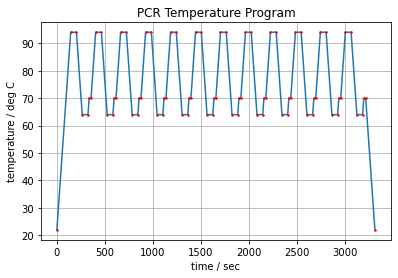

In [2]:
PCR_thermal_cycle('pcr/pcr1.csv')

Text(value='pcr/pcr2.csv', description='Filename')

Output()

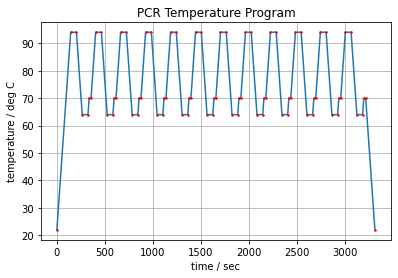

In [3]:
PCR_thermal_cycle('pcr/pcr2.csv')

interactive(children=(Combobox(value='pcr/pcr1.csv', description='file1', ensure_option=True), Combobox(value=…

<function __main__.get_data(file1, file2)>

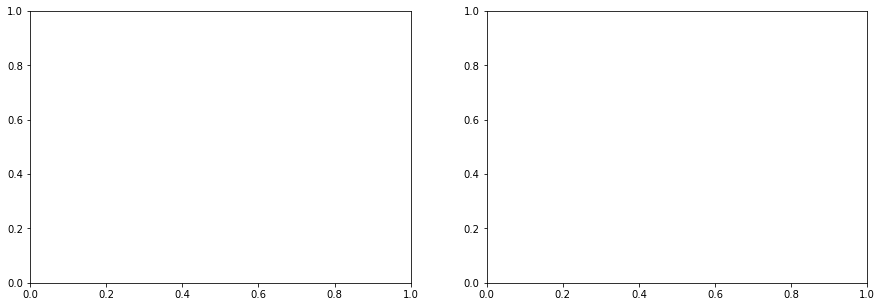

In [4]:
import glob
csv_files = glob.glob("pcr/*.csv")

def get_data(file1, file2):
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    if file1:
        df1 = pd.read_csv(file1)
        ax[0].plot(df1['tp'], df1['Tp'], 'b')
    if file2:
        df2 = pd.read_csv(file2)
        ax[0].plot(df2['tp'], df2['Tp'], 'r')
    ax[0].grid(True)
    if file1 and file2:
        tmax = max(df1['tp'].max(), df2['tp'].max())
        t = np.linspace(0, tmax, int(tmax+1))
        u1 = np.interp(t, df1['tp'].to_numpy(), df1['Tp'].to_numpy())
        u2 = np.interp(t, df2['tp'].to_numpy(), df2['Tp'].to_numpy())
        ax[1].plot(u1, u2)
        ax[1].axis('square')

widgets.interact(get_data, 
    file1 = widgets.Combobox(value="pcr/pcr1.csv", options=csv_files, ensure_option=True),
    file2 =  widgets.Combobox(value="pcr/pcr2.csv", options=csv_files, ensure_option=True)
)